# Exploratory Data Analysis (EDA)

## 1: Dataset Overview & Initial Cleaning

This section introduces the dataset and performs essential structural cleaning before deeper analysis.

The dataset consists of Palestinian news articles from 2023 to 2025. Each record contains:

- `title`: Article headline
- `content`: Full news text
- `date`: Publication date
- `platform`: Source (e.g., Al Jazeera, Misbar)
- `label`: Target classification (`real` or `fake`)

### 1.1 Load and Preview

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
%matplotlib inline

# Arabic text handling
import re
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder


# NLTK for Arabic stopwords/tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# Warnings off
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Walid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Walid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load dataset
news_df = pd.read_csv("../data/raw/original_news_data.csv", encoding='utf-8')

In [3]:
# preview data
display(news_df.head())
display(news_df.tail())
news_df.info()

,Id,date,platform,title,News content,Label
0,1,2023-01-11 00:00:00,Aljazeera,الضفة الغربية.. الاحتلال يهدم 17 منزلا تاريخيا...,هدمت قوات الاحتلال الإسرائيلي -اليوم الأربعاء-...,real
1,2,2023-01-11 00:00:00,Aljazeera,مظاهرات بمدن أوروبية تضامنا مع غزة وحشود أمام ...,خرجت مظاهرات في عدد من المدن الأوروبية مساء ال...,real
2,3,2023-01-11 00:00:00,Aljazeera,شهداء في جنين وطولكرم وإضراب عام بالضفة الغربي...,استشهد 4 فلسطينيين واعتقل عشرات آخرون -اليوم ا...,real
3,4,2023-02-11 00:00:00,Aljazeera,أبو عبيدة: خسائر العدو أكبر بكثير مما يعلن وسن...,أكد الناطق باسمكتائب الشهيد عز الدين القسام-ال...,real
4,5,2023-03-11 00:00:00,Aljazeera,9 شهداء بالضفة والاحتلال يشن حملة اعتقالات,استشهد 9 فلسطينيين في مواجهات اندلعت مع قوات ا...,real


,Id,date,platform,title,News content,Label
5347,5348,2025-05-30 00:00:00,Aljazeera,"الحرب على غزة مباشر.. مجازر إسرائيلية بمراكز ""...",في اليوم الـ77 من استئناف حرب الإبادة على غزة،...,real
5348,5349,2025-05-30 00:00:00,Misbar,الصورة ليست لجندي مغربي سقط في كمين للمقاومة ا...,تتداول حسابات على موقع التواصل الاجتماعي إكس، ...,fake
5349,5350,2025-05-30 00:00:00,Aljazeera,مظاهرات بإسرائيل تطالب بإكمال الصفقة وجدل حول ...,تظاهر محتجون وسط تل أبيب ليل الاثنين وأضرموا ا...,real
5350,5351,2025-05-30 00:00:00,Aljazeera,"زكريا الزبيدي حرا.. ""التنين"" الفلسطيني الذي هز...",لم يكن في مخيلة وزير الأمن القومي الإسرائيلي ا...,real
5351,5352,2025-05-30 00:00:00,Misbar,فيديو قديم لمعتمر يدعو لغزة خلال طوافه في الحر...,تتداول حسابات وصفحات على مواقع التواصل الاجتما...,fake


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5352 non-null   int64 
 1   date          5352 non-null   object
 2   platform      5352 non-null   object
 3   title         5352 non-null   object
 4   News content  5352 non-null   object
 5   Label         5352 non-null   object
dtypes: int64(1), object(5)
memory usage: 251.0+ KB


In [4]:
print("Unique values per column:")
print(news_df.nunique())

print("\nDuplicate rows total:", news_df.duplicated().sum())

Unique values per column:
Id              5352
date            1835
platform          26
title           5051
News content    5329
Label              2
dtype: int64

Duplicate rows total: 0


We observe that some columns are inconsistently named (`Label`, `News content`, `Id`). We'll fix naming and data types next.


### 1.2 Rename Columns & Fix Types

In [5]:
# Rename columns to follow snake_case convention
news_df.rename(columns={
    'Id': 'id',
    'News content': 'content',
    'Label': 'label'
}, inplace=True)

# Convert `date` to datetime format
news_df['date'] = pd.to_datetime(news_df['date'])

In [6]:
# Summary statistics
news_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,5352.0,NaN,NaN,NaN,2676.5,1.0,1338.75,2676.5,4014.25,5352.0,1545.133651
date,5352,NaN,NaN,NaN,2024-07-08 18:42:08.402466560,2011-03-20 00:00:00,2024-01-03 00:00:00,2024-08-04 17:34:00,2024-11-25 00:00:00,2025-06-23 00:00:00,NaN
platform,5352,26,Aljazeera,3422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,5352,5051,عاجل | مراسل #الجزيرة,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content,5352,5329,تتداول حسابات وصفحات على مواقع التواصل الاجتما...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,5352,2,real,3913,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now the dataframe has standardized column names and a valid datetime index.

### 1.3 Check for Nulls and Duplicates

In [7]:
# Null values check
news_df.isnull().sum()

id          0
date        0
platform    0
title       0
content     0
label       0
dtype: int64

In [8]:
# Check duplicates in key text fields
def check_duplicate(col):
    duplicate_count = news_df[col].duplicated().sum()
    return f"{col}: Duplicated entries = {duplicate_count}"

cols_dp = [check_duplicate(col) for col in news_df[["title", "content"]]]
cols_dp

['title: Duplicated entries = 301', 'content: Duplicated entries = 23']

As shown, there is 301 duplicated entries in "title" field, and 23 in "News content" field

In [9]:
# Remove duplicates
# First remove content duplicates (same article with reworded titles),
# then remove remaining title duplicates (exact reposts)
news_df = news_df.drop_duplicates(subset=['content'])
news_df = news_df.drop_duplicates(subset=['title'])

We first drop content duplicates to remove reworded headlines with same text, then title duplicates to clean up repeated coverage.

### 1.4 Arabic Reshaper
Reshape Arabic text for correct display in Matplotlib plots using arabic_reshaper and bidi.

In [10]:
import arabic_reshaper
from bidi.algorithm import get_display

def reshape_arabic(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    elif isinstance(text, list):
        return [get_display(arabic_reshaper.reshape(t)) for t in text]
    else:
        return text


## 2. Label Distribution

In this section, we examine the distribution of real and fake news articles in the dataset.

Understanding class balance is essential before model training, as imbalance can bias the model toward the majority class. We’ll visualize the label frequencies and compute exact proportions.


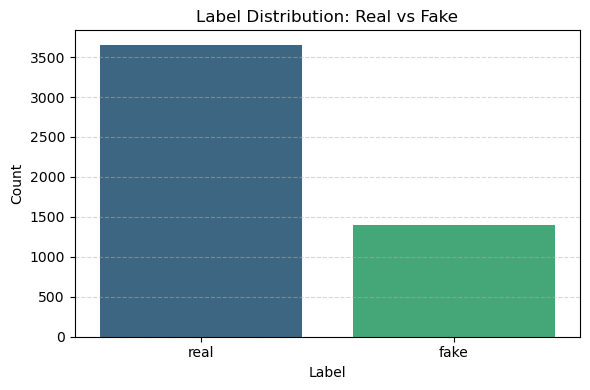

In [11]:
# Countplot
plt.figure(figsize=(6, 4))
sns.countplot(data=news_df, x='label', palette='viridis')

plt.title("Label Distribution: Real vs Fake")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
# Display numeric distribution
label_counts = news_df['label'].value_counts()
total = label_counts.sum()

for label, count in label_counts.items():
    percentage = (count / total) * 100
    print(f"{label}: {count} articles ({percentage:.2f}%)")

real: 3652 articles (72.30%)
fake: 1399 articles (27.70%)


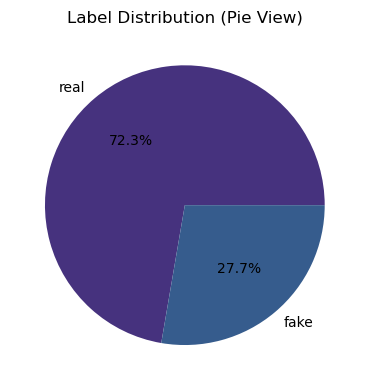

In [13]:
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title("Label Distribution (Pie View)")
plt.tight_layout()
plt.show()


- The dataset is **moderately imbalanced**, with ~72% real and ~28% fake.
- While not extreme, the imbalance may skew classification metrics such as accuracy.
- **Precision**, **recall**, **F1**, or **AUC** will be more reliable than accuracy during evaluation.
- We will address this later using:
    - Resampling (SMOTE, undersampling)
    - Class weights
    - Threshold tuning

## 3. Platform & Source Analysis

We examine where the news originates from to understand platform influence and credibility. This includes:
- Identifying top contributing sources
- Grouping rare platforms to reduce noise
- Analyzing how platform relates to label (fake vs. real)

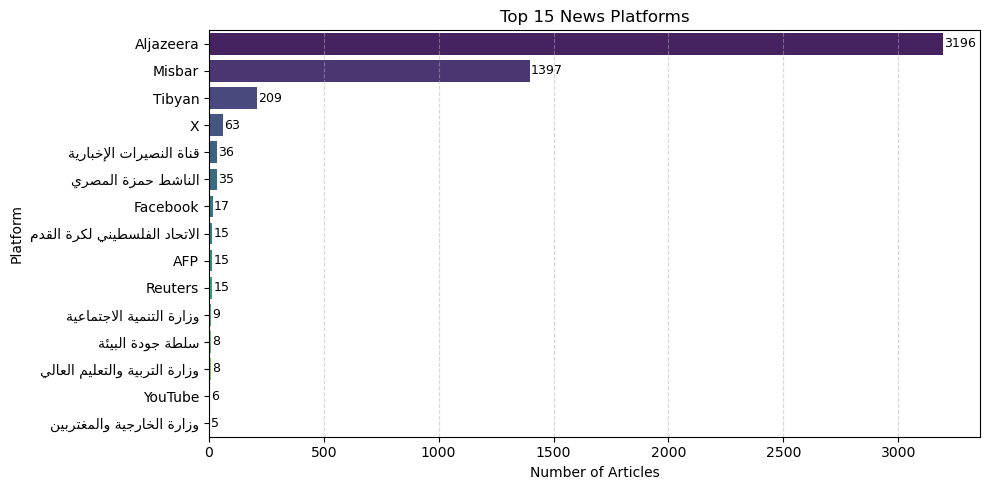

In [14]:
# Top platforms by frequency
plt.figure(figsize=(10, 5))
top_platforms = news_df['platform'].value_counts().head(15)

# Apply Arabic reshaping to y-axis labels
reshaped_labels = [reshape_arabic(label) for label in top_platforms.index]

sns.barplot(x=top_platforms.values, y=reshaped_labels, palette="viridis")
plt.title("Top 15 News Platforms")
plt.xlabel("Number of Articles")
plt.ylabel("Platform")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add count labels next to bars
for i, v in enumerate(top_platforms.values):
    plt.text(v + 5, i, str(v), va='center', fontsize=9)
    
plt.tight_layout()
plt.show()


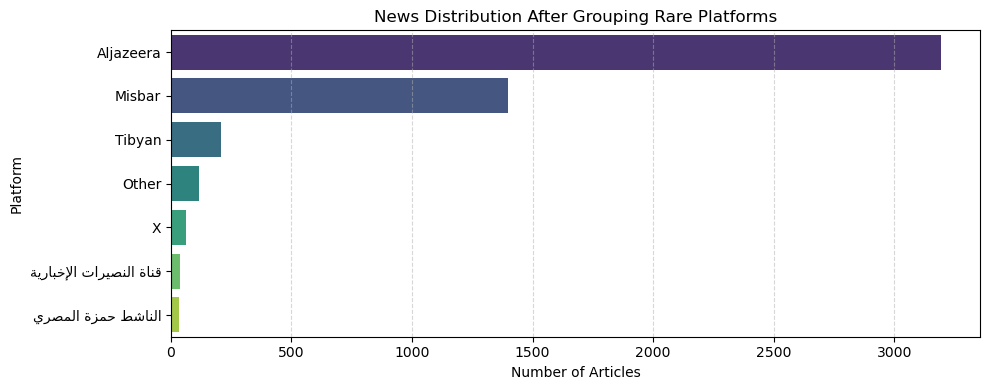

In [15]:
# Count platform occurrences
platform_counts = news_df['platform'].value_counts()

# Set a threshold (e.g., keep only platforms with >= 30 entries)
threshold = 30

# Create a new column grouping rare platforms as "Other"
news_df['platform_grouped'] = news_df['platform'].apply(
    lambda x: x if platform_counts[x] >= threshold else 'Other'
)

# Reshape y-tick labels
grouped_counts = news_df['platform_grouped'].value_counts()
reshaped_labels = [reshape_arabic(label) for label in grouped_counts.index]

# Plot
plt.figure(figsize=(10, 4))
sns.countplot(
    data=news_df,
    y='platform_grouped',
    order=grouped_counts.index,
    palette="viridis"
)

plt.title("News Distribution After Grouping Rare Platforms")
plt.xlabel("Number of Articles")
plt.ylabel("Platform")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.yticks(ticks=range(len(reshaped_labels)), labels=reshaped_labels)

plt.tight_layout()
plt.show()

To reduce the effect of long-tail platforms that appear fewer than 30 times, we grouped them under the label "Other"

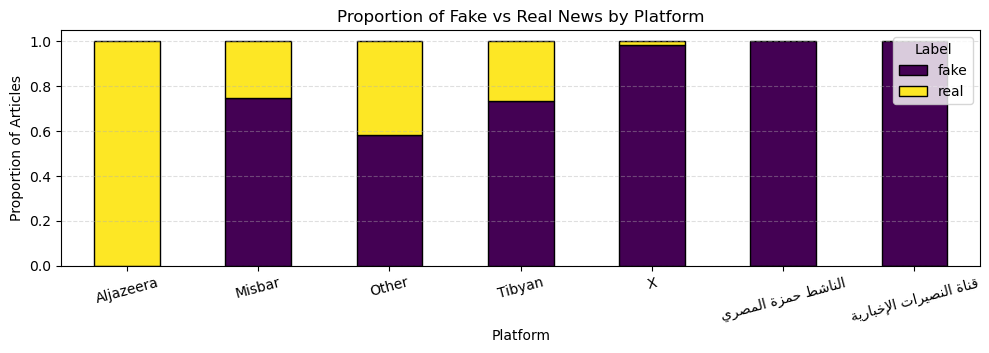

In [16]:
# Cross-tab (normalized row-wise)
platform_label_crosstab = pd.crosstab(
    news_df['platform_grouped'],
    news_df['label'],
    normalize='index'
)

# Plot stacked bar chart
ax = platform_label_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis',
    edgecolor='black'
)

plt.title("Proportion of Fake vs Real News by Platform")
plt.xlabel("Platform")
plt.ylabel("Proportion of Articles")
plt.legend(title="Label", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# Reshape Arabic x-tick labels (platform names)
reshaped_xtick_labels = [reshape_arabic(label) for label in platform_label_crosstab.index]
ax.set_xticklabels(reshaped_xtick_labels, rotation=15)

plt.show()


- **Top Contributors:** Al Jazeera, Misbar, and Tibyan dominate the dataset.
- **Platform Bias:** Al Jazeera contributes mostly real news, while Misbar and X are skewed toward fake.
- **Rare Sources:** Grouping platforms with <30 articles into "Other" improved readability.
- **Implication:** Platform source is a strong feature — possibly encoding credibility or agenda. This insight will guide modeling and bias mitigation later.

## 4. Text Length Analysis
This section explores article length patterns to understand writing styles across real and fake news. We analyze both titles and full content using word counts and visualizations.

### Title and Content Length Overview

In [17]:
# Add new columns for word count
news_df['title_length'] = news_df['title'].apply(lambda x: len(str(x).split()))
news_df['content_length'] = news_df['content'].apply(lambda x: len(str(x).split()))

In [18]:
for col in ['title_length', 'content_length']:
    print(f"{col}:")
    print(f"  Mean:   {news_df[col].mean():.2f}")
    print(f"  Median: {news_df[col].median():.2f}")
    print(f"  Std:    {news_df[col].std():.2f}")
    print(f"  Min:    {news_df[col].min()}")
    print(f"  Max:    {news_df[col].max()}")
    print()


title_length:
  Mean:   9.62
  Median: 10.00
  Std:    4.53
  Min:    1
  Max:    59

content_length:
  Mean:   228.58
  Median: 45.00
  Std:    417.64
  Min:    1
  Max:    10717



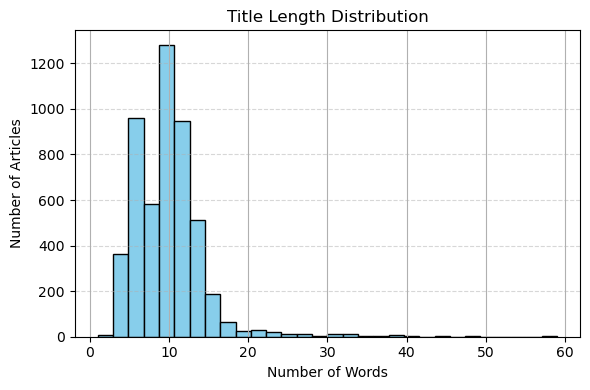

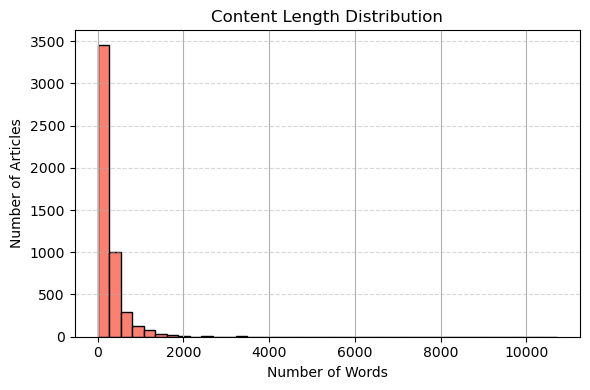

In [19]:
# Histogram for title length
plt.figure(figsize=(6, 4))
news_df['title_length'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Title Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram for content length
plt.figure(figsize=(6, 4))
news_df['content_length'].hist(bins=40, color='salmon', edgecolor='black')
plt.title("Content Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 4.2 Length Differences Between Real and Fake News

In [20]:
real_titles = news_df[news_df['label'] == 'real']['title_length']
fake_titles = news_df[news_df['label'] == 'fake']['title_length']
real_content = news_df[news_df['label'] == 'real']['content_length']
fake_content = news_df[news_df['label'] == 'fake']['content_length']

In [21]:
# Print results
print("Average Title and Content Length by Label:\n")
print(f"Real News - Title Length Mean:   {real_titles.mean():.2f}")
print(f"Fake News - Title Length Mean:   {fake_titles.mean():.2f}")
print(f"Real News - Content Length Mean: {real_content.mean():.2f}")
print(f"Fake News - Content Length Mean: {fake_content.mean():.2f}")

Average Title and Content Length by Label:

Real News - Title Length Mean:   9.13
Fake News - Title Length Mean:   10.90
Real News - Content Length Mean: 282.39
Fake News - Content Length Mean: 88.09


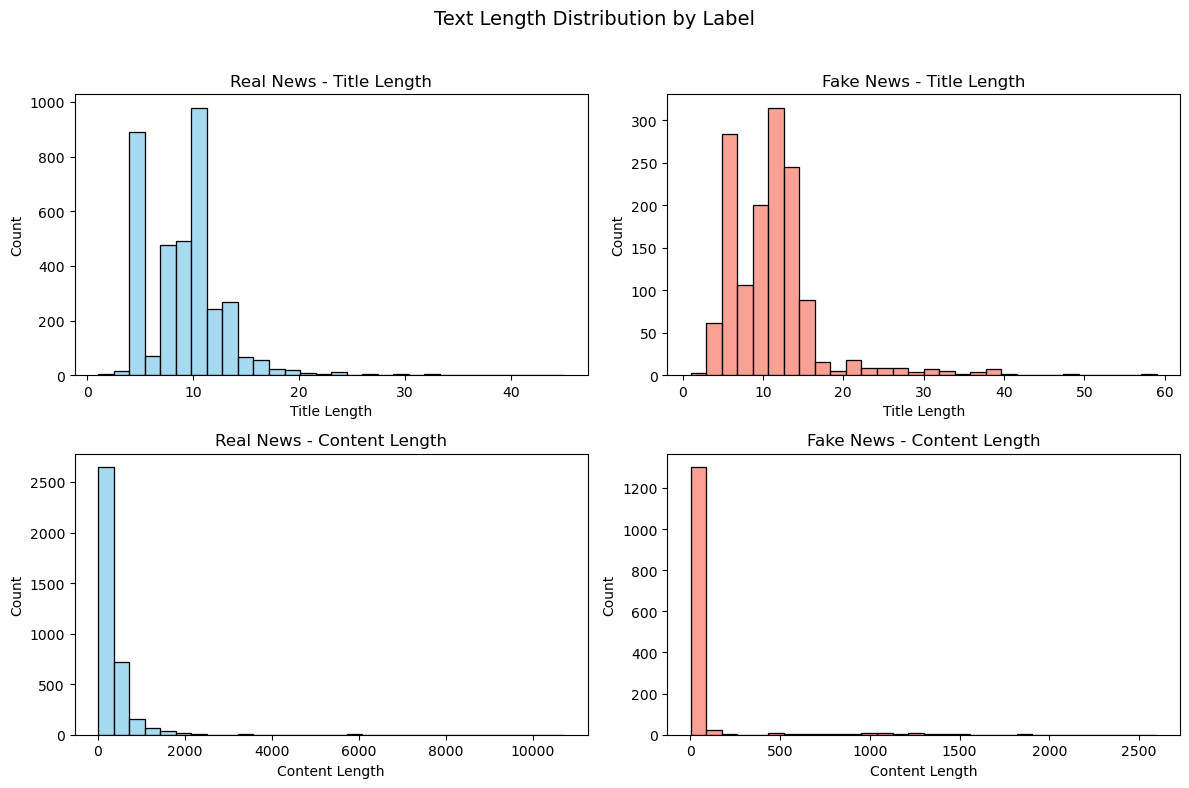

In [22]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Text Length Distribution by Label", fontsize=14)

# Plot 1: Real Titles
sns.histplot(real_titles, ax=axs[0, 0], color='skyblue', bins=30)
axs[0, 0].set_title("Real News - Title Length")
axs[0, 0].set_xlabel("Title Length")
axs[0, 0].set_ylabel("Count")

# Plot 2: Fake Titles
sns.histplot(fake_titles, ax=axs[0, 1], color='salmon', bins=30)
axs[0, 1].set_title("Fake News - Title Length")
axs[0, 1].set_xlabel("Title Length")
axs[0, 1].set_ylabel("Count")

# Plot 3: Real Content
sns.histplot(real_content, ax=axs[1, 0], color='skyblue', bins=30)
axs[1, 0].set_title("Real News - Content Length")
axs[1, 0].set_xlabel("Content Length")
axs[1, 0].set_ylabel("Count")

# Plot 4: Fake Content
sns.histplot(fake_content, ax=axs[1, 1], color='salmon', bins=30)
axs[1, 1].set_title("Fake News - Content Length")
axs[1, 1].set_xlabel("Content Length")
axs[1, 1].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

### 4.3 Addressing Skew: Log & Outlier Filtering

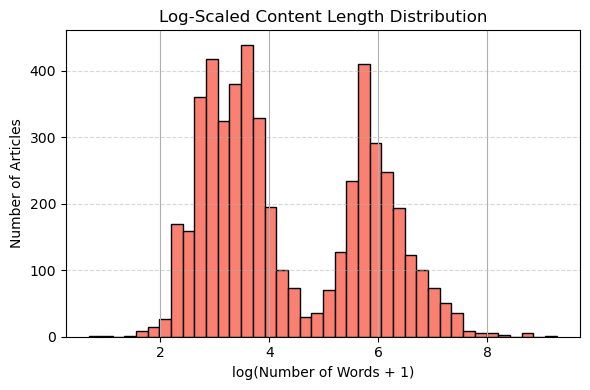

In [23]:
plt.figure(figsize=(6, 4))
news_df['content_length'].apply(lambda x: np.log1p(x)).hist(bins=40, color='salmon', edgecolor='black')
plt.title("Log-Scaled Content Length Distribution")
plt.xlabel("log(Number of Words + 1)")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


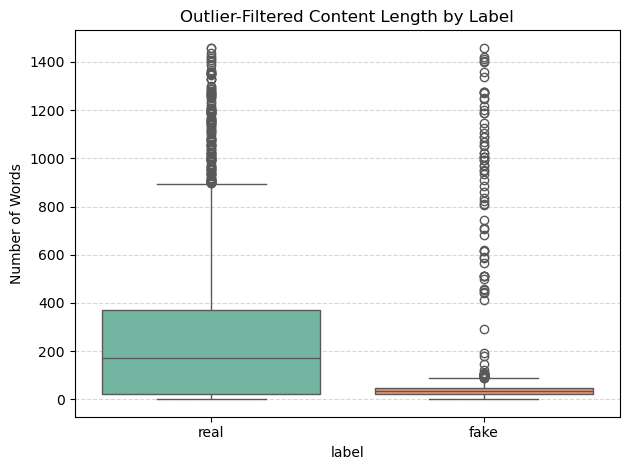

In [24]:
# Filter out extreme outliers using Z-score method
filtered = news_df[np.abs(zscore(news_df['content_length'])) < 3]

# Plot boxplot after outlier removal
sns.boxplot(data=filtered, x='label', y='content_length', palette="Set2")
plt.title("Outlier-Filtered Content Length by Label")
plt.ylabel("Number of Words")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- **Title Length**: Most article titles are short, with an average of ~9.6 words. The distribution is right-skewed, but overall fairly consistent.
- **Content Length**: Content length shows high variance. While the mean is ~228 words, the median is only 45 — indicating that a few very long articles inflate the average.
- **Real vs Fake**: Real news articles tend to have significantly longer content compared to fake ones. However, fake news sometimes has slightly longer titles on average.
- **Label-wise Distribution**: Subplot comparisons show real news has more spread and longer content, while fake news is more concentrated in shorter ranges.
- **Log-Scaled View**: A log transformation of content length reveals a bimodal distribution, suggesting two common length patterns — possibly short-format fake news vs long-format real articles.
- **Boxplot Insights**: Outliers are frequent in both classes, but more extreme in real news. Filtering them still shows real content being richer and more detailed.


# 5. Correlation

In [25]:
news_df['platform_encoded'] = LabelEncoder().fit_transform(news_df['platform_grouped'])
news_df['label_encoded'] = news_df['label'].map({'real': 0, 'fake': 1})

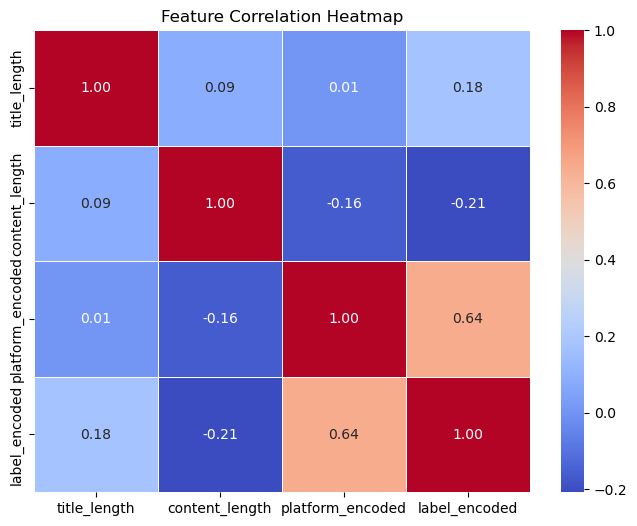

In [26]:
# Compute correlation matrix on numeric features
corr = news_df[["title_length", "content_length", "platform_encoded", "label_encoded"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

- platform_encoded shows a strong positive correlation with the label (0.64), indicating platform source may influence whether news is fake or real.
- title_length has a weak positive correlation with the label, suggesting minor predictive value.
- content_length has a weak negative correlation, showing limited standalone usefulness.
- These results imply that while text length is not very informative, platform metadata could carry bias or signal worth analyzing further.

## 6. Word Analysis

We explore lexical differences between real and fake news using word frequency statistics and word clouds.

In [27]:
def clean_arabic_text(text):
    """Remove unsupported unicode, punctuation, and stopwords."""
    text = re.sub(r'[\u2066\u2067\u2068\u2069]', '', text)  # Remove control codes
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)          # Keep Arabic only
    arabic_stopwords = set(stopwords.words('arabic'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in arabic_stopwords]
    return " ".join(tokens)

def reshape_for_wordcloud(text):
    """Apply Arabic reshaping and bidi reordering."""
    reshaped = arabic_reshaper.reshape(text)
    return get_display(reshaped)


In [28]:
real_text_raw = " ".join(news_df[news_df['label'] == 'real']['content'].astype(str))
fake_text_raw = " ".join(news_df[news_df['label'] == 'fake']['content'].astype(str))

# Cleaning (stopwords + punctuation)
real_text_clean = clean_arabic_text(real_text_raw)
fake_text_clean = clean_arabic_text(fake_text_raw)

# Prepare display-ready for word cloud
real_text_ready = reshape_for_wordcloud(real_text_clean)
fake_text_ready = reshape_for_wordcloud(fake_text_clean)

In [29]:
real_tokens = word_tokenize(real_text_clean)
real_common_words = Counter(real_tokens).most_common(20)

fake_tokens = word_tokenize(fake_text_clean)
fake_common_words = Counter(fake_tokens).most_common(20)

print("Most common words in Real news:")
for word, count in real_common_words:
    print(f"{word}: {count}")

print("Most common words in Fake news:")
for word, count in fake_common_words:
    print(f"{word}: {count}")

Most common words in Real news:
غزة: 7293
الاحتلال: 5815
الإسرائيلي: 5640
إسرائيل: 4031
قطاع: 3512
الإسرائيلية: 2953
خلال: 2604
وفي: 2451
غزة،: 2429
الجيش: 2409
حماس: 2316
اليوم: 2312
قوات: 2280
الحرب: 2219
المقاومة: 1905
الجزيرة: 1886
الأول: 1857
،: 1791
أنه: 1721
مدينة: 1657
Most common words in Fake news:
غزة: 1209
التواصل: 625
الإسرائيلي: 596
قطاع: 589
فيديو: 556
حسابات: 542
مقطع: 532
خلال: 518
أنه: 500
إسرائيل: 471
حديثًا،: 464
الاحتلال: 457
مواقع: 452
الإسرائيلية: 452
تتداول: 429
حماس: 395
الاجتماعي،: 384
مسبار: 374
وصفحات: 368
غزة،: 367


| Word         | Real Count | Fake Count |
|--------------|------------|------------|
| غزة           | 7293       | 1209       |
| الاحتلال       | 5815       | 457        |
| الإسرائيلي     | 5640       | 596        |
| إسرائيل       | 4031       | 471        |
| قطاع          | 3512       | 589        |
| الإسرائيلية    | 2953       | 452        |
| خلال          | 2604       | 518        |
| وفي           | 2451       | –          |
| غزة،          | 2429       | 367        |
| الجيش         | 2409       | –          |
| حماس          | 2316       | 395        |
| اليوم         | 2312       | –          |
| قوات          | 2280       | –          |
| الحرب         | 2219       | –          |
| المقاومة      | 1905       | –          |
| الجزيرة       | 1886       | –          |
| الأول         | 1857       | –          |
| أنه           | 1721       | 500        |
| مدينة         | 1657       | –          |
| التواصل       | –          | 625        |
| فيديو         | –          | 556        |
| حسابات        | –          | 542        |
| مقطع          | –          | 532        |
| حديثًا،       | –          | 464        |
| مواقع         | –          | 452        |
| تتداول        | –          | 429        |
| الاجتماعي،     | –          | 384        |
| مسبار         | –          | 374        |
| وصفحات        | –          | 368        |


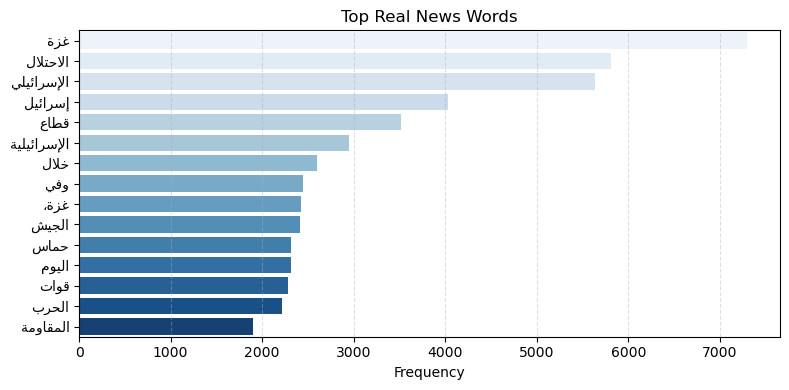

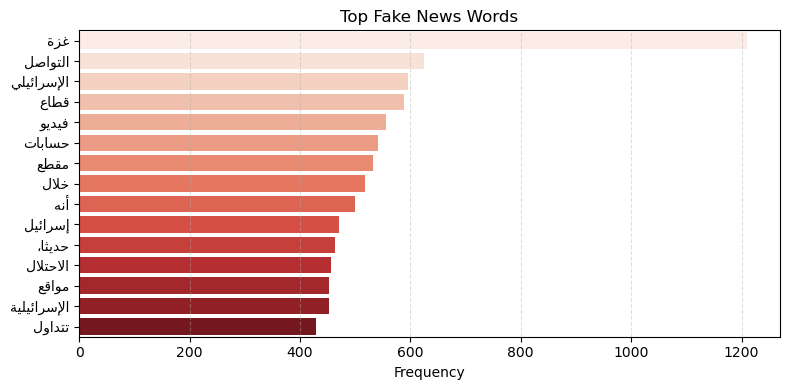

In [30]:
def plot_top_words(word_freq, title, color):
    words, counts = zip(*word_freq[:15])
    
    reshaped_words = reshape_arabic(list(words))

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts), y=reshaped_words, palette=color)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Plot the reshaped Arabic word frequencies
plot_top_words(real_common_words, "Top Real News Words", "Blues")
plot_top_words(fake_common_words, "Top Fake News Words", "Reds")

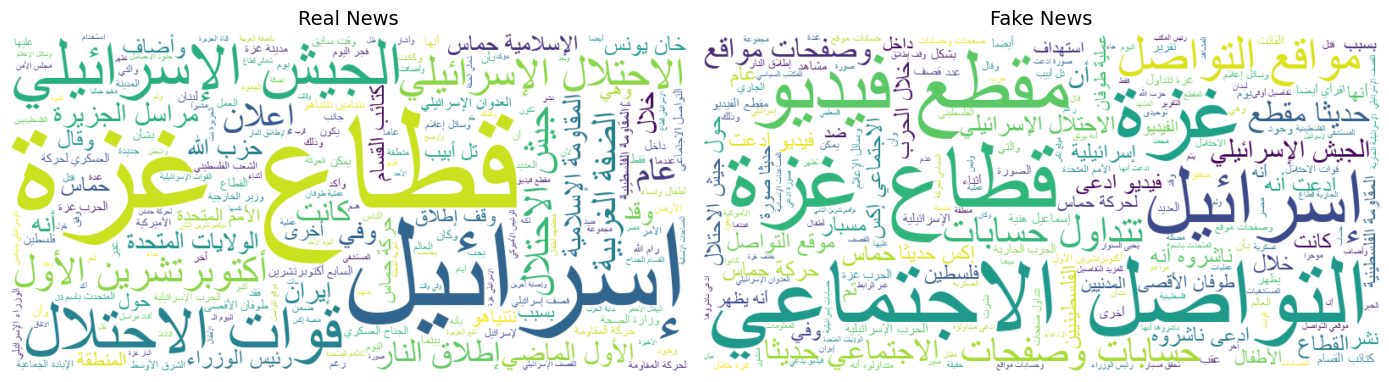

In [31]:
# generate word cloud
plt.figure(figsize=(14, 6))

# Real News
plt.subplot(1, 2, 1)
wordcloud_real = WordCloud(font_path='arial', width=800, height=400, background_color='white').generate(real_text_ready)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News", fontsize=14)

# Fake News
plt.subplot(1, 2, 2)
wordcloud_fake = WordCloud(font_path='arial', width=800, height=400, background_color='white').generate(fake_text_ready)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News", fontsize=14)

plt.tight_layout()
plt.show()

- **Real news** articles heavily emphasize **military events** and **political organizations**.
- **Fake news** focuses on **media virality** — platforms, videos, and content-sharing behaviors.
- These lexical patterns are distinctive and **strong candidates for feature engineering** (e.g., keyword TF-IDF, presence flags).


## 7. Temporal & Seasonal Trends

We explore how real and fake news volume changes over time to identify seasonality, surges, and misinformation bursts.

This includes weekly and monthly patterns, label breakdowns, and historical relevance filtering.


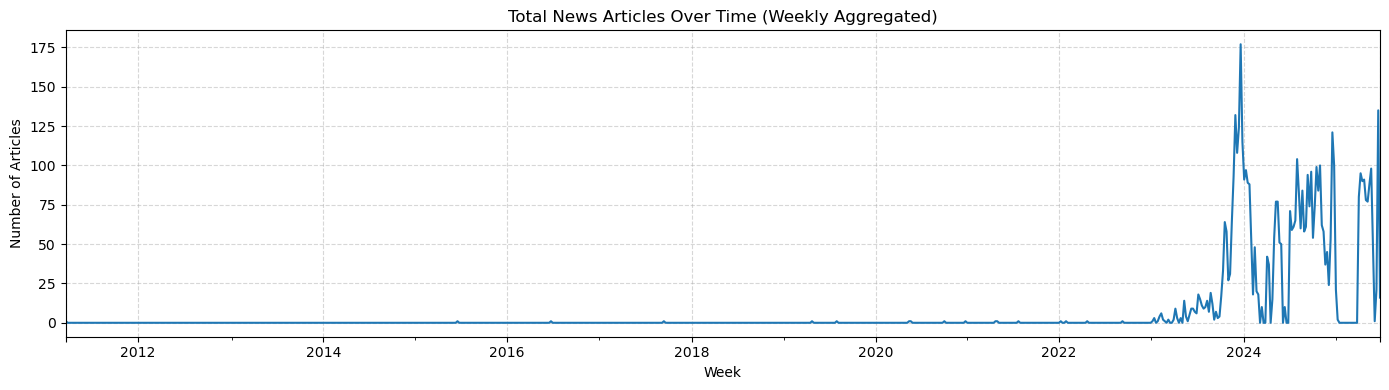

In [32]:
# Weekly total article count
news_df.set_index('date', inplace=True)
weekly_total = news_df.resample('W').size()

plt.figure(figsize=(14, 4))
weekly_total.plot()
plt.title("Total News Articles Over Time (Weekly Aggregated)")
plt.xlabel("Week")
plt.ylabel("Number of Articles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Article activity is mostly flat until 2023, when volume begins increasing. The 2023 Gaza-Israel conflict marks a sharp surge.


In [33]:
# Articles before 2023
news_df.reset_index(inplace=True)
before_2023 = news_df[news_df['date'] < '2023-01-01']
print(f"Articles before 2023: {before_2023.shape[0]}")
before_2023[['date', 'platform', 'title']].sort_values('date').head(10)

Articles before 2023: 17


,date,platform,title
1569,2011-03-20,Aljazeera,ماذا تعرف عن صواريخ توماهوك؟
1570,2015-06-18,Aljazeera,البرنامج النووي الإيراني
1571,2016-06-21,Aljazeera,خمس شخصيات في حياة الراحلة سعاد حسني
1572,2017-09-12,Aljazeera,سعاد حسني في “بئر الحرمان”.. الغوص في أعماق ا...
1573,2019-04-28,Aljazeera,مضيق هرمز.. نهر النفط المهدد بالنضوب
1574,2019-07-30,Aljazeera,سندريلا الشاشة العربية.. قُتلت أم انتحرت؟
1575,2020-05-12,Aljazeera,بدأت في العهد النبوي واتخِذت مؤقِّتا للسحور وش...
1576,2020-05-23,Aljazeera,مذاقات شرقية – 3 إيران
1577,2020-09-30,Aljazeera,السينما المصرية.. انتصاران لسعاد حسني على محظو...
1578,2020-12-23,Aljazeera,واصف جوهرية.. يد تكتب تاريخ القدس وأخرى تعزف ا...


In [34]:
# Drop articles before 2023-01-01 — they are irrelevant noise
news_df = news_df[news_df['date'] >= '2023-01-01'].copy()
news_df.reset_index(drop=True, inplace=True)

**Note:** 17 old articles (2011–2020) were removed for being off-topic or irrelevant. These distorted early trends and are excluded from analysis.

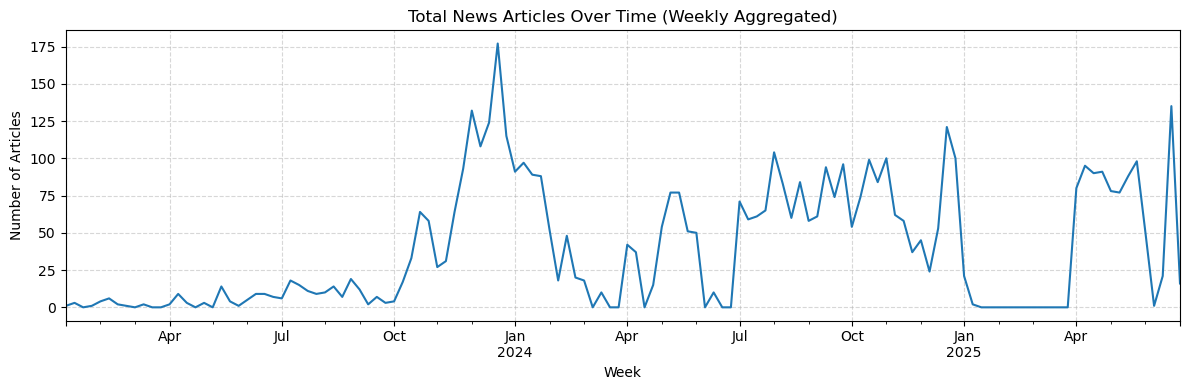

In [35]:
# Group and resample by week
news_df.set_index('date', inplace=True)
weekly_counts = news_df.resample('W').size()

# Plot weekly smoothed version
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
weekly_counts.plot()
plt.title("Total News Articles Over Time (Weekly Aggregated)")
plt.xlabel("Week")
plt.ylabel("Number of Articles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

From October 2023 onward, article volume shows sustained activity with several dips and recoveries.


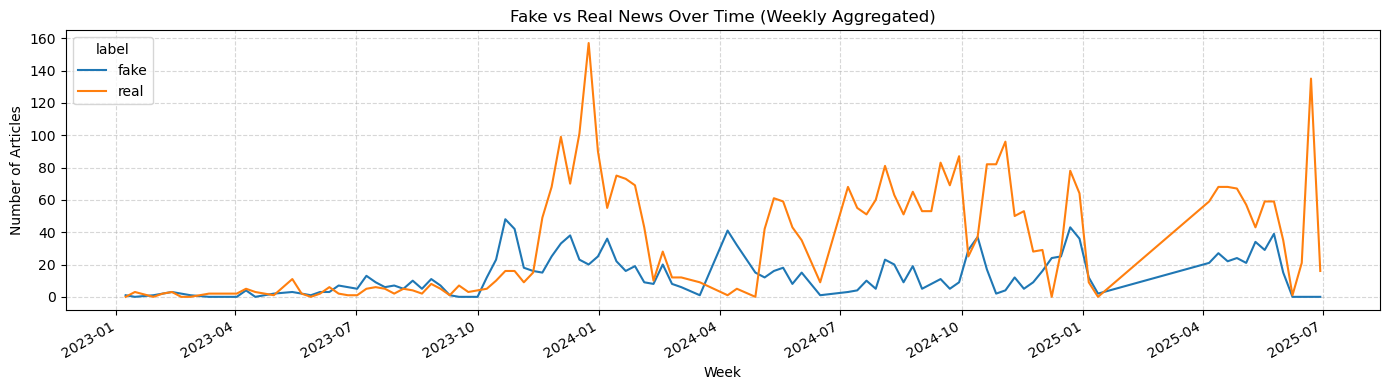

In [36]:
# Weekly count by label
weekly_label_counts = news_df.groupby([pd.Grouper(freq='W'), 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 4))
weekly_label_counts.plot(ax=plt.gca())
plt.title("Fake vs Real News Over Time (Weekly Aggregated)")
plt.xlabel("Week")
plt.ylabel("Number of Articles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Real news consistently dominates volume. Fake news exhibits sharp, sporadic spikes—especially in late 2023 and early 2025.


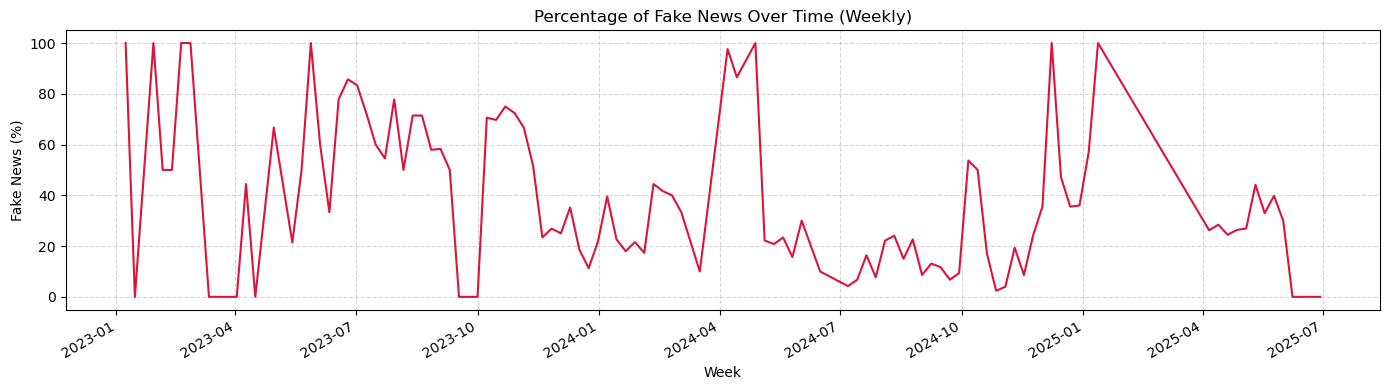

In [37]:
# Compute % of fake news weekly
weekly_pct = weekly_label_counts.copy()
weekly_pct['fake_pct'] = (weekly_pct['fake'] / weekly_pct.sum(axis=1)) * 100

plt.figure(figsize=(14, 4))
weekly_pct['fake_pct'].plot(color='crimson')
plt.title("Percentage of Fake News Over Time (Weekly)")
plt.ylabel("Fake News (%)")
plt.xlabel("Week")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In some weeks, fake news makes up 80–100% of all articles—often during social/media-driven misinformation bursts.


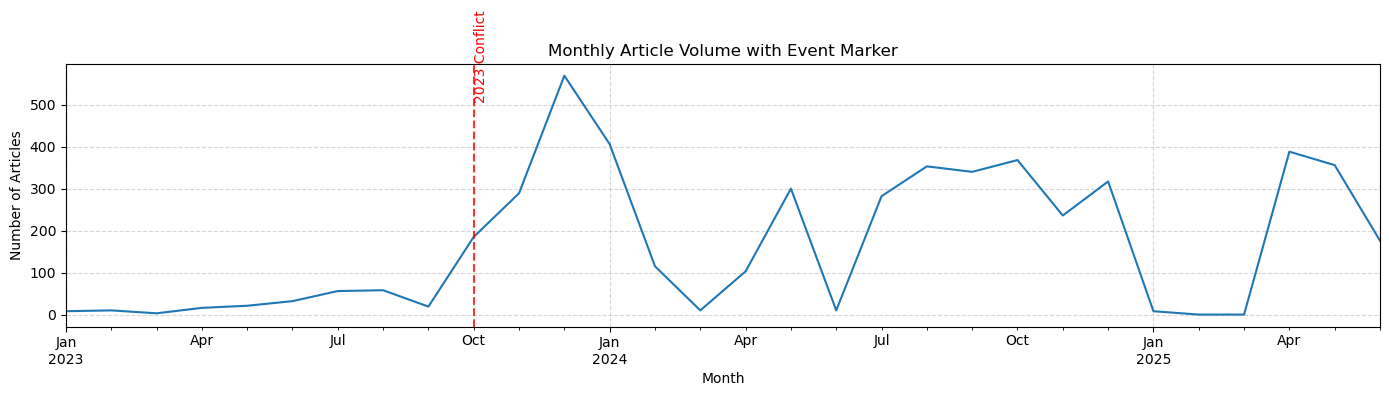

In [38]:
# Monthly total
monthly = news_df.resample('M').size()

plt.figure(figsize=(14, 4))
monthly.plot()
plt.axvline(pd.to_datetime('2023-10-07'), color='red', linestyle='--', alpha=0.8)
plt.text(pd.to_datetime('2023-10-07'), monthly.max()*0.9, '2023 Conflict', rotation=90, color='red')
plt.title("Monthly Article Volume with Event Marker")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The spike aligns exactly with the October 2023 Gaza-Israel conflict. Media attention remains elevated throughout 2024–2025.



- **Time Filtering**: Pre-2023 articles were removed to avoid distortion and focus on current conflict-related patterns.
- **Conflict-Driven Spikes**: Sharp surges in news activity follow real-world crises (Oct 2023).
- **Fake News Patterns**: Fake news surges in bursts, likely tied to viral moments or disinfo campaigns.
- **Feature Opportunity**: Time is a strong contextual feature — we’ll engineer features like `month`, `is_post_war`, and `week` to help our model understand temporal signals.

## 8. Final Summary & Next Steps

This exploratory data analysis examined over 5,300 Palestinian news articles (2023–2025) from verified and unverified sources. Through structured cleaning and domain-informed insights, we uncovered patterns in source credibility, lexical style, temporal shifts, and content structure that inform our downstream fake news detection pipeline.

---

### ✅ Data Cleaning Summary

- **Dropped Duplicates**:
  - 301 duplicate headlines
  - 23 duplicate content rows
- **Renamed Columns** for consistency:
  - `News content` → `content`
  - `Label` → `label` (lowercase)
- **Converted Types**:
  - `date` → `datetime`
- **Removed Irrelevant Articles**:
  - 17 non-Palestine articles from 2011–2020 excluded
- **Text Columns Cleaned**:
  - Stopword removal for lexical analysis
  - Unicode cleanup and Arabic reshaping for visualization
- **Feature Engineering**:
  - `title_length` and `content_length` extracted
  - `platform_grouped` created for handling rare sources

---

### 📊 Key Insights from EDA

- **Platform Bias**:
  - Al Jazeera dominates real news
  - Misbar, Tibyan, and social platforms drive fake content
- **Lexical Patterns**:
  - Real news uses terms tied to geopolitics (e.g., "المقاومة", "الاحتلال")
  - Fake news leans toward viral/social terms ("فيديو", "مقطع")
- **Text Length**:
  - Real articles are longer and more diverse
  - Fake articles are brief and repetitive
- **Temporal Trends**:
  - Strong spike after October 2023 conflict
  - Fake news exhibits bursty behavior tied to real-world events

---

### 🔧 Next Steps

#### Data Preparation (`cleaner.py`)
- Move all transformation logic from notebook into pipeline-ready functions:
  - Rename, drop duplicates, type conversion
  - Remove outliers using IQR or z-score (e.g., `content_length`)
  - Add engineered features (`length`, `platform_grouped`, `is_post_conflict`)
- Export cleaned dataset: `data/merged_cleaned.csv`

#### Modeling Pipeline
- Vectorize Arabic text using TF-IDF or embeddings
- Experiment with models (Naive Bayes, Logistic Regression, SVM, etc.)
- Handle imbalance using:
  - Class weighting
  - Oversampling (SMOTE or simple duplication)
  - Threshold moving

#### Feature Engineering (Advanced)
- Add features like:
  - `title_verb_ratio`
  - `platform_encoded`
  - `content_length_log`
  - `keyword_presence_flags`

#### Deployment-Readiness
- Save trained model to `/models/`
- Build a minimal `app/` with:
  - Input form (text or URL)
  - Prediction + confidence
  - Label explanation
